In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt

In [16]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd

In [18]:
X_train=[]
classes = os.listdir('/content/drive/MyDrive/duck_chicken/train')
for cat in classes:
  for img in os.listdir('/content/drive/MyDrive/duck_chicken/train/'+cat):
    try:
      X_train.append(cv2.resize(cv2.imread('/content/drive/MyDrive/duck_chicken/train/'+cat+'/'+img),(224,224)))
    except:
      continue


In [19]:
X_test=[]
classes = os.listdir('/content/drive/MyDrive/duck_chicken/test')
for cat in classes:
  for img in os.listdir('/content/drive/MyDrive/duck_chicken/test/'+cat):
    try:
      X_test.append(cv2.resize(cv2.imread('/content/drive/MyDrive/duck_chicken/test/'+cat+'/'+img),(224,224)))
    except:
      continue

In [20]:
X_val=[]
classes = os.listdir('/content/drive/MyDrive/duck_chicken/val')
for cat in classes:
  for img in os.listdir('/content/drive/MyDrive/duck_chicken/val/'+cat):
    try:
      X_val.append(cv2.resize(cv2.imread('/content/drive/MyDrive/duck_chicken/val/'+cat+'/'+img),(224,224)))
    except:
      continue

In [33]:
X_train_arr = np.array(X_train)/255.0
X_test_arr = np.array(X_test)/255.0
X_val_arr = np.array(X_val)/255.0

In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/duck_chicken/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/duck_chicken/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/duck_chicken/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 300 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [36]:
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [39]:
y_train=training_set.classes
y_test=test_set.classes
y_val=val_set.classes

In [40]:
# fit the model
history = model.fit(
  X_train_arr,
  y_train,
  validation_data=(X_val_arr,y_val),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
10/10 [==============================] - 291s 30s/step - loss: 1.6135 - accuracy: 0.5133 - val_loss: 1.8052 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 260s 26s/step - loss: 0.6818 - accuracy: 0.6767 - val_loss: 1.8496 - val_accuracy: 0.2333
Epoch 3/10
10/10 [==============================] - 294s 30s/step - loss: 0.3675 - accuracy: 0.8433 - val_loss: 2.0088 - val_accuracy: 0.1500
Epoch 4/10
10/10 [==============================] - 295s 30s/step - loss: 0.2284 - accuracy: 0.9133 - val_loss: 2.0581 - val_accuracy: 0.1833
Epoch 5/10
10/10 [==============================] - 257s 26s/step - loss: 0.1825 - accuracy: 0.9633 - val_loss: 2.0625 - val_accuracy: 0.1667
Epoch 6/10
10/10 [==============================] - 293s 30s/step - loss: 0.1421 - accuracy: 0.9800 - val_loss: 2.1792 - val_accuracy: 0.1833
Epoch 6: early stopping


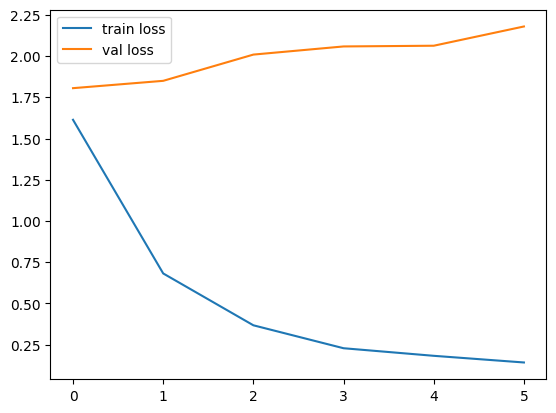

In [41]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

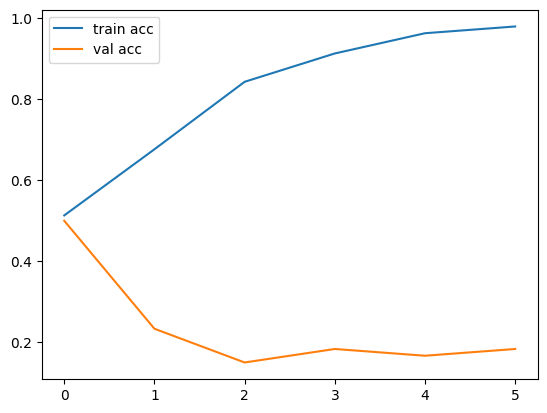

In [42]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [43]:
model.evaluate(X_test_arr,y_test,batch_size=32)

4/4 [==============================] - 73s 16s/step - loss: 0.5999 - accuracy: 0.7100


[0.599886417388916, 0.7099999785423279]

In [44]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [46]:
y_pred=model.predict(X_test_arr)
y_pred=np.argmax(y_pred,axis=1)

4/4 [==============================] - 73s 17s/step


In [47]:
accuracy_score(y_pred,y_test)

0.71

In [48]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.78      0.68      0.73        57
           1       0.64      0.74      0.69        43

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.72      0.71      0.71       100



In [53]:
y_test_word =[]
for i in y_test:
  if i==0:
    y_test_word.append('chicken')
  else:
    y_test_word.append('duck')

y_pred_word =[]
for i in y_pred:
  if i==0:
    y_pred_word.append('chicken')
  else:
    y_pred_word.append('duck')


Text(0.5, 1.0, 'Actual Label:chicken, Predicted Label:chicken')

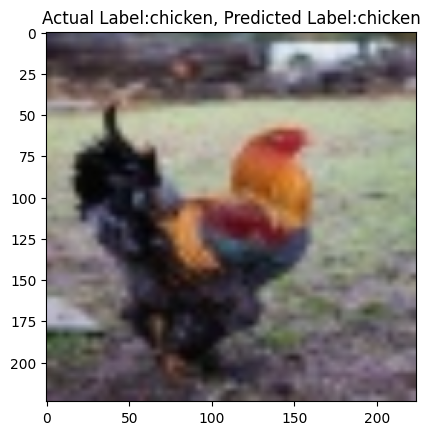

In [61]:
plt.imshow(cv2.cvtColor(X_test[0], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[0]}, Predicted Label:{y_pred_word[0]}')

Text(0.5, 1.0, 'Actual Label:chicken, Predicted Label:chicken')

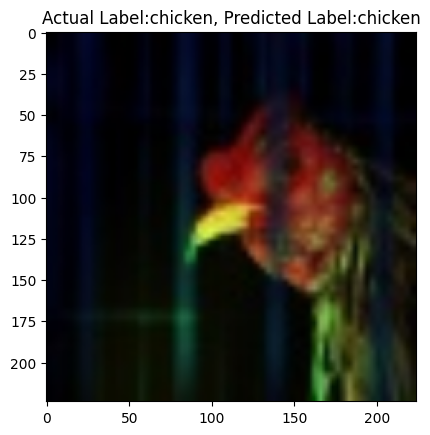

In [62]:
plt.imshow(cv2.cvtColor(X_test[5], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[5]}, Predicted Label:{y_pred_word[5]}')

Text(0.5, 1.0, 'Actual Label:duck, Predicted Label:duck')

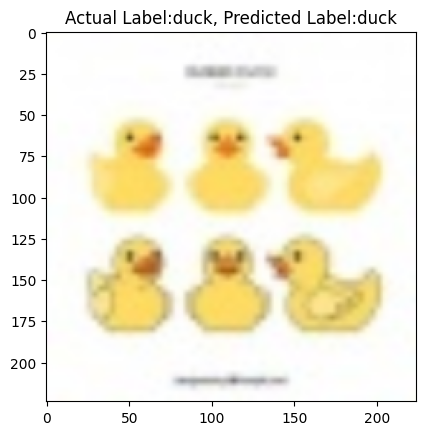

In [71]:
plt.imshow(cv2.cvtColor(X_test[50], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[50]}, Predicted Label:{y_pred_word[50]}')

Text(0.5, 1.0, 'Actual Label:duck, Predicted Label:duck')

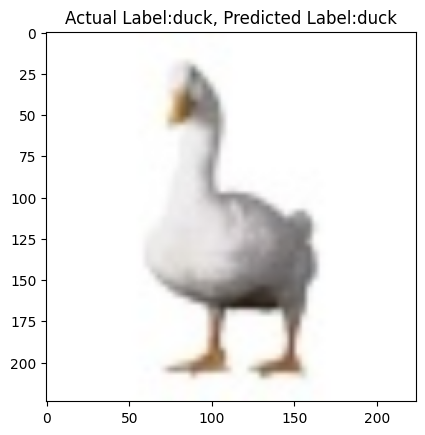

In [72]:
plt.imshow(cv2.cvtColor(X_test[-1], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[-1]}, Predicted Label:{y_pred_word[-1]}')

Text(0.5, 1.0, 'Actual Label:duck, Predicted Label:chicken')

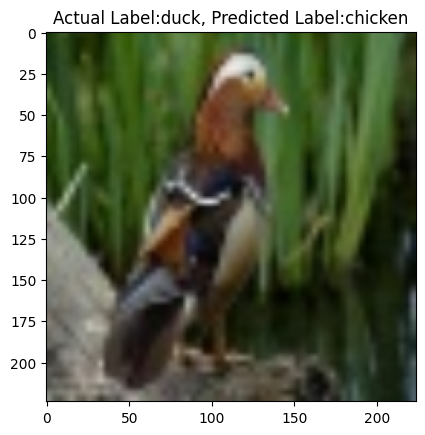

In [70]:
plt.imshow(cv2.cvtColor(X_test[58], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[58]}, Predicted Label:{y_pred_word[58]}')

Text(0.5, 1.0, 'Actual Label:duck, Predicted Label:chicken')

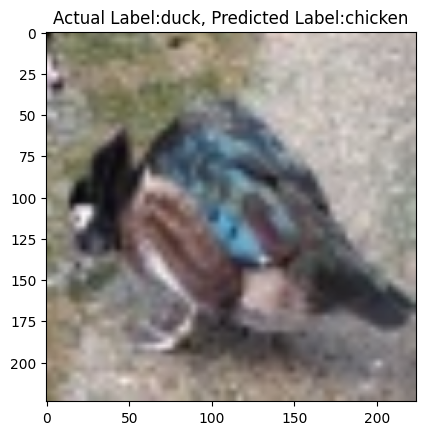

In [74]:
plt.imshow(cv2.cvtColor(X_test[-3], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[-3]}, Predicted Label:{y_pred_word[-3]}')